# Evaluating the Performance of MiDaS on Drone Data
---

Here you can configure the script to work with your data.

In [22]:
bag_file_name = 'test3.bag'
data_filename = 'data.pickle'


topic_cam1 = '/d455/infra1/image_rect_raw'
topic_cam2 = '/d455/infra2/image_rect_raw'
topic_depth = '/d455/depth/image_rect_raw'

# running MiDaS
input_path = 'input'
output_path = 'output'

model_path = 'weights/dpt_large_384.pt'
model_type = 'dpt_large_384'

optimize=False
side=False
height=None
square=False
grayscale=True # Realsense output is grayscale


# =============================================
idx_analysed_frame = -200

## Getting drone footage

In [23]:
import os
import rosbag
import bag2data as b2d
import cv2
import matplotlib.pyplot as plt
import numpy as np
import run
import pickle

In [24]:
if bag_file_name.endswith(".bag"):
    test_run = bag_file_name[:-4]  # remove ".bag" from the end of the filename
else:
    raise ValueError("File extension must be .bag")

print('In this run of the script we are investigating \'' + test_run + '\'.')
print('In case the analysis has already been performed and data has been saved, the saved data will be used to save computational time.')

In this run of the script we are investigating 'test3'.
In case the analysis has already been performed and data has been saved, the saved data will be used to save computational time.


In [25]:
# Load pickle file

try:
    with open(data_filename, 'rb') as file:
        data = pickle.load(file)
        file.close()
        print('\'data\' loaded.')
        
except FileNotFoundError:
    # If the file doesn't exist, create it with some initial data
    data = {}
    with open(data_filename, 'wb') as file:
        pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)
    file.close()
    print('Created \'data\'.')

'data' loaded.


In [26]:
bag = rosbag.Bag(os.path.join('drone_data', bag_file_name))

# get data from rosbag
image_data_infra1_ros = b2d.getImageData(bag, topic_cam1)
image_data_infra2_ros = b2d.getImageData(bag, topic_cam2)

# transform data into list of numpy arrays/matrices
image_data_infra1_np = b2d.ros_IMG_2numpy(image_data_infra1_ros)
image_data_infra2_np = b2d.ros_IMG_2numpy(image_data_infra2_ros)

print("The bags contain", len(image_data_infra1_np), "and", len(image_data_infra2_np), "Frames.")

The bags contain 843 and 840 Frames.


In [27]:
if test_run in data:
    print('\'Data\' already contains data for \'' +  test_run + '\'.')
    if model_type in data[test_run]:
        print('\'Data\' also already contains data for \'' + model_type + '\'.')
        if 'cam1' in data[test_run][model_type]:
            if len(data[test_run][model_type]['cam1']) != len(image_data_infra1_np):
                data[test_run][model_type]['cam1'] = image_data_infra1_np
                print('Added \'cam1\' to \'' + model_type + '\' in \'' + test_run + '\'.')
        else:
            data[test_run][model_type]['cam1'] = image_data_infra1_np
            print('Added \'cam1\' to \'' + model_type + '\' in \'' + test_run + '\'.')
        if 'cam2' in data[test_run][model_type]:
            if len(data[test_run][model_type]['cam2']) != len(image_data_infra2_np):
                data[test_run][model_type]['cam2'] = image_data_infra2_np
                print('Added \'cam2\' to \'' + model_type + '\' in \'' + test_run + '\'.')
        else:
            data[test_run][model_type]['cam2'] = image_data_infra1_np
            print('Added \'cam2\' to \'' + model_type + '\' in \'' + test_run + '\'.')


    else: 
        print('\'Data\' does not contain data for ' + model_type + ' and will be added now.')
        data[test_run][model_type] = {}
        data[test_run][model_type]['cam1'] = image_data_infra1_np
        data[test_run][model_type]['cam2'] = image_data_infra2_np
        print('Added \'cam1\' and \'cam2\' to ' + model_type + '\' in \'' + test_run + '\'.')
else: 
    print('\'data\' does not contain data for ' +  test_run + ' and will be added now.')
    data[test_run] = {}
    data[test_run][model_type] = {}
    data[test_run][model_type]['cam1'] = image_data_infra1_np
    data[test_run][model_type]['cam2'] = image_data_infra2_np
    print('Added \'cam1\' and \'cam2\' to \'' + model_type + '\' in \'' + test_run + '\'.')


# save data to pickle file
with open("data.pickle", "wb") as file:
    pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)
    file.close()

# data[test_run][model_type]['depth'] = []
# data[test_run][model_type]['depth_estimate1'] = []
# data[test_run][model_type]['depth_estimate2'] = []

# if 'depth' in data[test_run][model_type]:
# if 'depth_estimate1' in data[test_run][model_type]:
# if 'depth_estimate2' in data[test_run][model_type]:

'Data' already contains data for 'test3'.
'Data' also already contains data for 'dpt_large_384'.


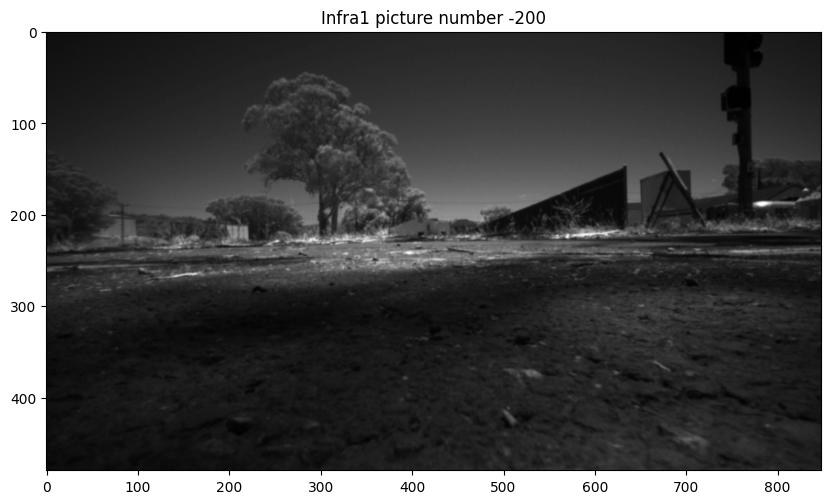

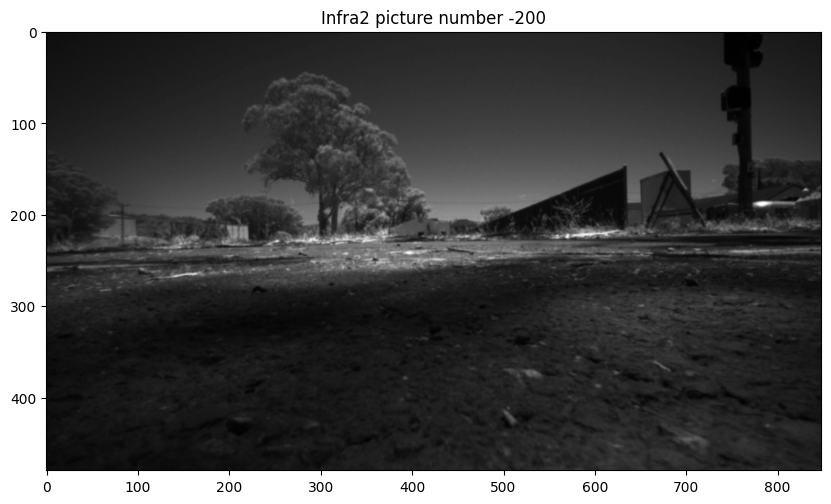

In [28]:
# show infra1
fig = plt.figure(figsize =(10, 10))
plt.imshow(data[test_run][model_type]['cam1'][idx_analysed_frame],cmap='gray')
plt.title("Infra1 picture number " + str(idx_analysed_frame))
plt.show()

# show infra2
fig = plt.figure(figsize =(10, 10))
plt.imshow(data[test_run][model_type]['cam1'][idx_analysed_frame],cmap='gray')
plt.title("Infra2 picture number " + str(idx_analysed_frame))
plt.show()

## Estimating depth in drone footage

In [29]:
# run MiDaS on data from rosbag
run.run(data_filename, test_run,'cam1', output_path, model_path, model_type, optimize, side, height, square, grayscale)

Initialize
Device: cpu
Model loaded, number of parameters = 344M
'data' loaded.
Start processing
Finished


In [30]:
with open(data_filename, 'rb') as file:
    data = pickle.load(file)
    file.close()
    print('\'data\' loaded.')

'data' loaded.


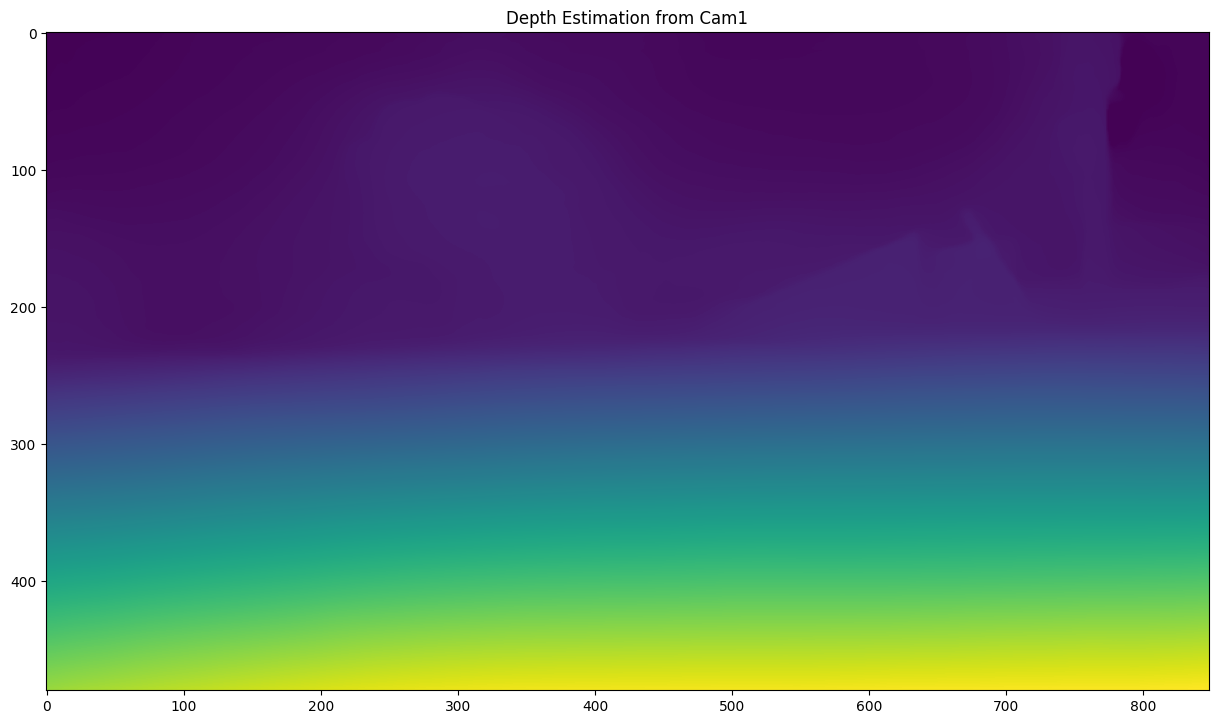

In [31]:
fig = plt.figure(figsize =(15, 15))
plt.imshow(data[test_run][model_type]['depth_estimate1'][idx_analysed_frame])
plt.title("Depth Estimation from Cam1")
plt.show()

## Getting "real" depth from Intel Realsense

In [32]:
bag = rosbag.Bag(os.path.join('drone_data', bag_file_name))

depth_data_ros = b2d.getDepthData(bag, topic_depth)
depth_measurement_images = b2d.ros_DEPTH_2numpy(depth_data_ros)

In [33]:
with open(data_filename, 'rb') as file:
    data = pickle.load(file)
    file.close()
    print('\'data\' loaded.')

'data' loaded.


In [34]:
new_category = 'depth_rs'

if test_run in data:
    print('\'Data\' already contains data for \'' +  test_run + '\'.')
    if model_type in data[test_run]:
        print('\'Data\' also already contains data for \'' + model_type + '\'.')
        if new_category in data[test_run][model_type]:
            if len(data[test_run][model_type][new_category]) != len(depth_measurement_images):
                data[test_run][model_type][new_category] = depth_measurement_images
                print('Added \'' + new_category + '\' to \'' + model_type + '\' in \'' + test_run + '\'.')
        else:
            data[test_run][model_type][new_category] = depth_measurement_images
            print('Added \'' + new_category + '\' to \'' + model_type + '\' in \'' + test_run + '\'.')
    else: 
        print('\'Data\' does not contain data for ' + model_type + ' and will be added now.')
        data[test_run][model_type] = {}
        data[test_run][model_type][new_category] = depth_measurement_images
        print('Added \'' + new_category + '\' to \'' + model_type + '\' in \'' + test_run + '\'.')
else: 
    print('\'data\' does not contain data for \'' +  test_run + '\' and will be added now.')
    data[test_run] = {}
    data[test_run][model_type] = {}
    data[test_run][model_type][new_category] = depth_measurement_images
    print('Added \'' + new_category + '\' to \'' + model_type + '\' in \'' + test_run + '\'.')

'Data' already contains data for 'test3'.
'Data' also already contains data for 'dpt_large_384'.


In [35]:
# save data to pickle file
with open("data.pickle", "wb") as file:
    pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)
    file.close()

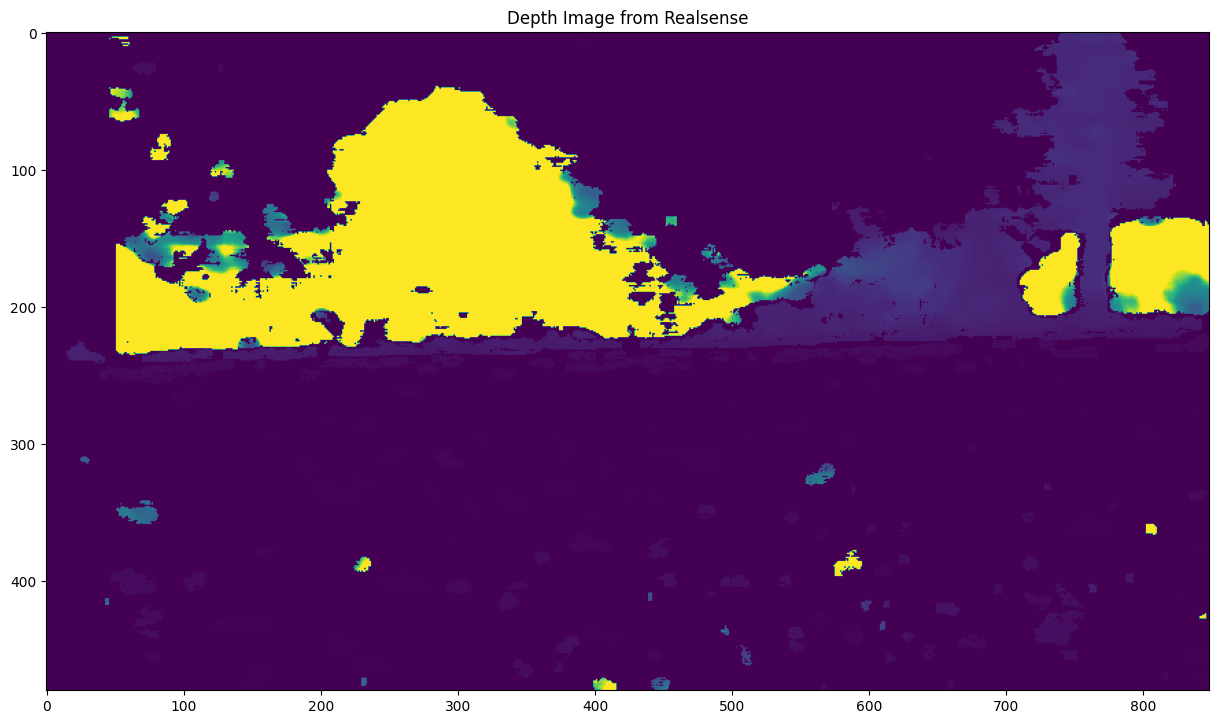

In [36]:
fig = plt.figure(figsize =(15, 15))
plt.imshow(data[test_run][model_type]['depth_rs'][idx_analysed_frame])
plt.title("Depth Image from Realsense")
plt.show()

## Comparing estimation to "ground truth"

In [37]:
'''
We have:
    - depth_estimate_images         [0-65534 or 65535] ?! TODO: check this
    - depth_measurement_images      [0-65535] in mm // TODO: Check if actually mm (could also be value set in camera-options)
'''
# max_depth = depth_measurement_images[idx_analysed_frame].max()
# difference_pic_zero = depth_estimate_images[idx_analysed_frame]/255 + depth_measurement_images[idx_analysed_frame]/max_depth

max_measured_depth = data[test_run][model_type]['depth_rs'][idx_analysed_frame].max()
print('Maximum measured depth: ' + str(max_measured_depth))

max_estimated1_depth = data[test_run][model_type]['depth_estimate1'][idx_analysed_frame].max()
# max_estimated2_depth = data[test_run][model_type]['depth_estimate1'][idx_analysed_frame].max()
print('Maximum estimated depth: ' + str(max_estimated1_depth))



difference_pic = data[test_run][model_type]['depth_estimate1'][idx_analysed_frame]/max_estimated1_depth + data[test_run][model_type]['depth_rs'][idx_analysed_frame]/max_measured_depth



Maximum measured depth: 65535
Maximum estimated depth: 65535


## Results

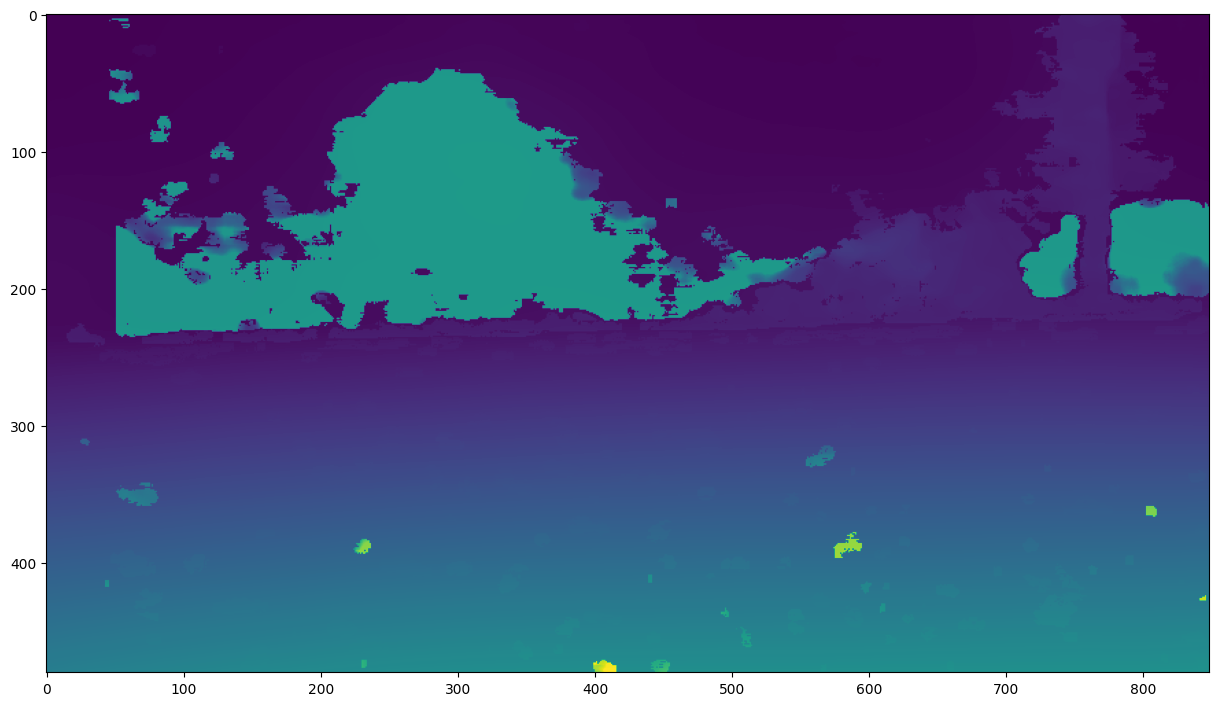

In [38]:
fig = plt.figure(figsize =(15, 15))
plt.imshow(difference_pic) # cmap='gray'
plt.show()

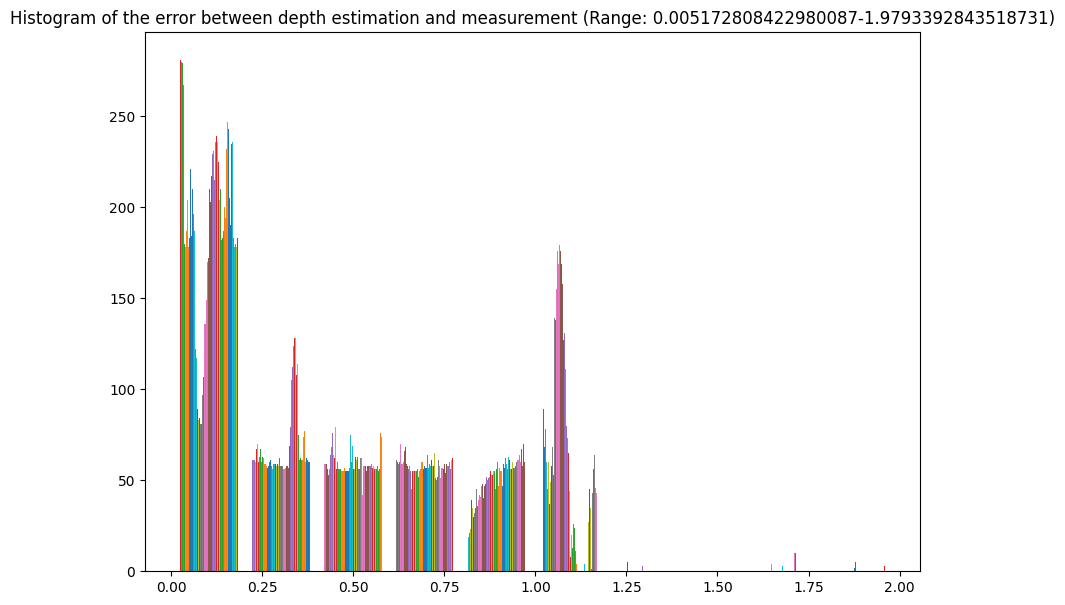

In [39]:
fig = plt.figure(figsize =(10, 7))

plt.hist(difference_pic)   #, bins=10 

max_error = difference_pic.max()
min_error = difference_pic.min()
text="Histogram of the error between depth estimation and measurement (Range: " + str(min_error) + "-" + str(max_error) + ")"

plt.title(text)
plt.show()

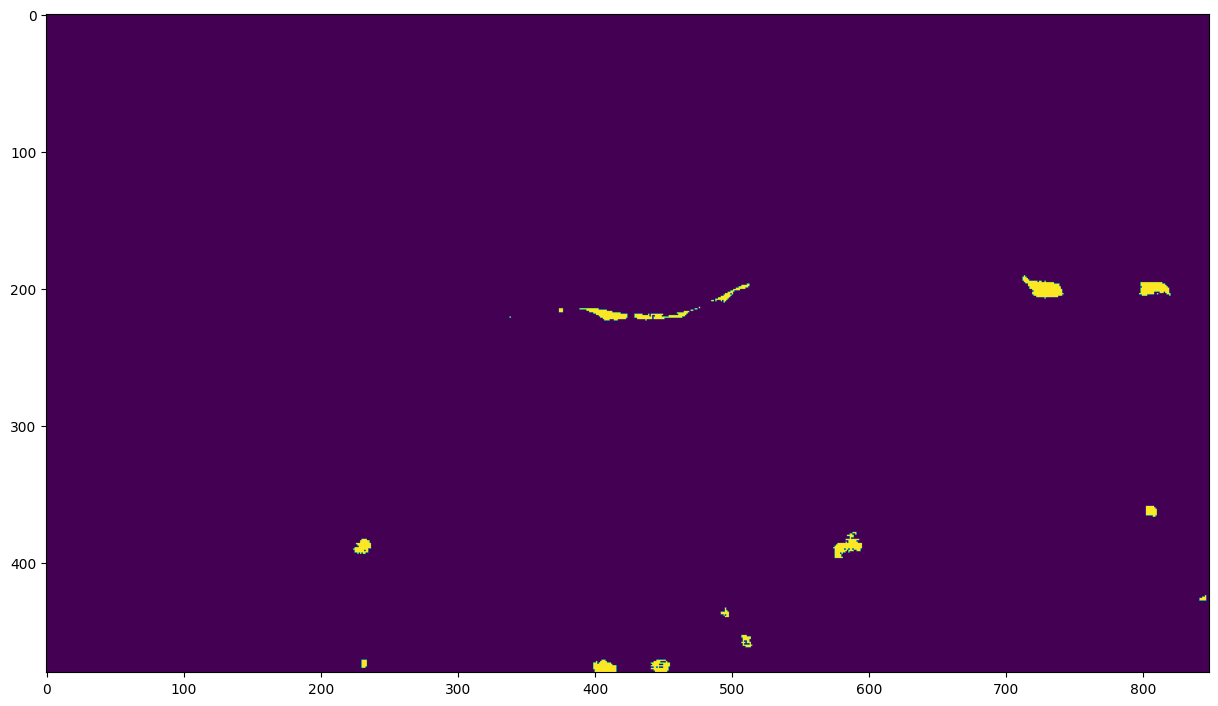

In [40]:
error_matrix = difference_pic

# Find the unique values in the array
unique_values = np.unique(error_matrix)

# Sort the unique values in descending order and get the 10 largest ones
largest_values = np.sort(unique_values)[::-1][:1000]

# Create a Boolean mask that sets the largest 10 unique values to True
mask = np.isin(error_matrix, largest_values)

difference_pic_zero_extremes = np.zeros_like(error_matrix)
difference_pic_zero_extremes[mask] = 255


fig = plt.figure(figsize =(15, 15))
plt.imshow(difference_pic_zero_extremes)
plt.show()

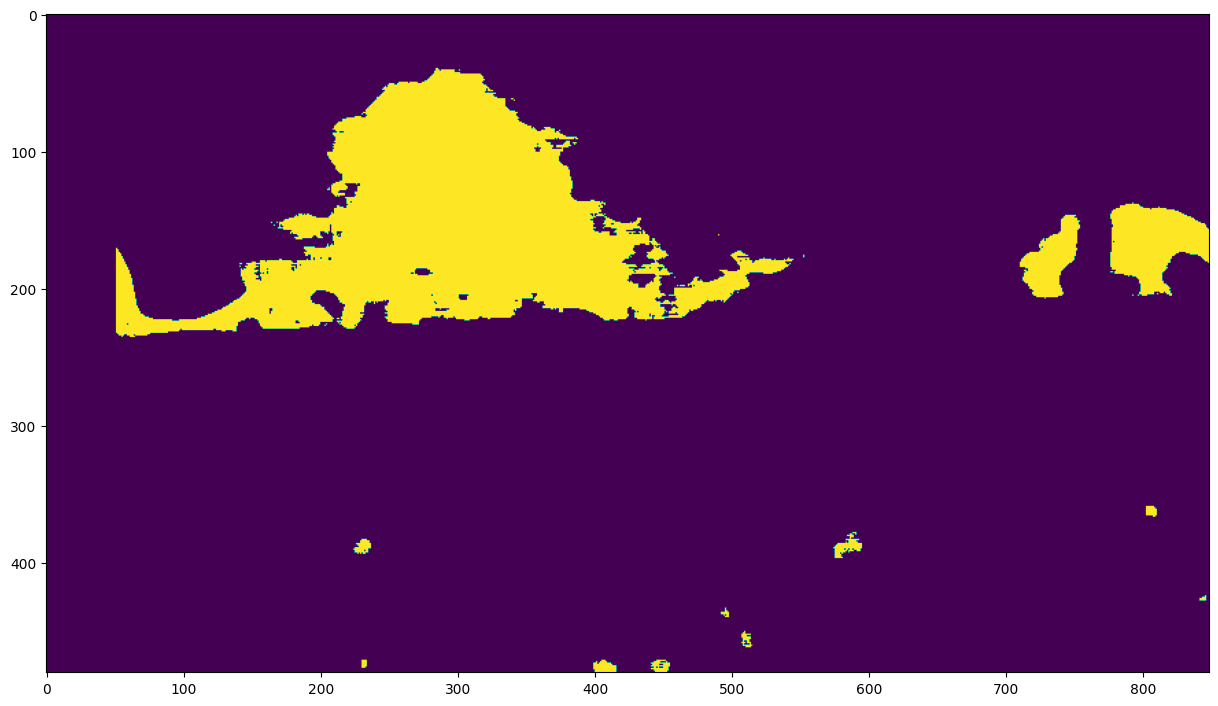

In [41]:
error_matrix = difference_pic

# Find the unique values in the array
unique_values = np.unique(error_matrix)

# Sort the unique values in descending order and get the 10 largest ones
largest_values = np.sort(unique_values)[::-1][:3500]

# Create a Boolean mask that sets the largest 10 unique values to True
mask = np.isin(error_matrix, largest_values)

difference_pic_zero_extremes = np.zeros_like(error_matrix)
difference_pic_zero_extremes[mask] = 255


fig = plt.figure(figsize =(15, 15))
plt.imshow(difference_pic_zero_extremes)
plt.show()

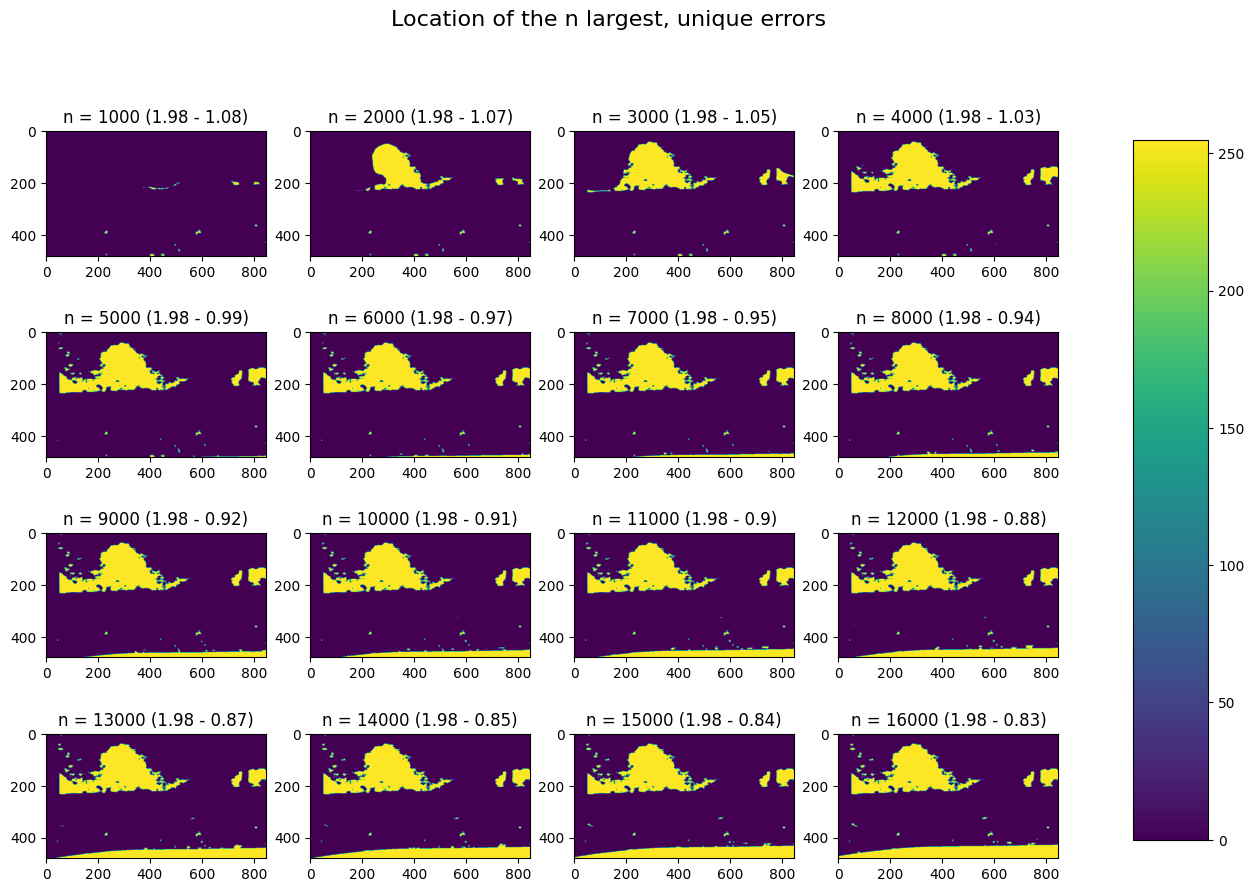

In [42]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize =(15, 10))
for idx, ax in enumerate(axes.flat):

    error_matrix = difference_pic

    # Find the unique values in the array
    unique_values = np.unique(error_matrix)

    # Sort the unique values in descending order and get the 'largest_amount' largest ones
    largest_amount = 1000*(idx+1)
    largest_values = np.sort(unique_values)[::-1][:(largest_amount)]

    # Create a Boolean mask that sets the largest 10 unique values to True
    mask = np.isin(error_matrix, largest_values)

    difference_pic_zero_extremes = np.zeros_like(error_matrix)
    difference_pic_zero_extremes[mask] = 255

    # fig = plt.figure(figsize =(15, 15))
    roundingval = 2
    text = "n = "+str(largest_amount) + " (" + str(round(largest_values[0],roundingval)) + " - " +str(round(largest_values[-1],roundingval)) + ")"
    ax.set_title(text)   
    
    im = ax.imshow(difference_pic_zero_extremes, vmin=0, vmax=255)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle('Location of the n largest, unique errors', fontsize=16)
plt.show()
# plt.colorbar(label="error", orientation="horizontal")


We can see the following:
* *HIGH MAGNITUDE ERRORS*: Very <ins>small artifacts</ins> in various places without obvious pattern 
* *MEDIUM MAGNITUDE ERRORS*: Larger areas of <ins>lower accuracy</ins> in the <ins>background</ins>
* *LOW MAGNITUDE ERRORS*: Tendency of errors in the <ins>foreground</ins>